### 二値分類モデル　改訂版

### 必要ライブラリの導入

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# 共通事前処理

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.2f}'.format

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

### データ準備

#### データ読み込み

In [3]:
from sklearn.datasets import load_iris

# アイリスデータセットをロード
iris = load_iris(as_frame=True)
#print(iris.DESCR)  # データセットの説明

df = iris.data
df.columns = ['がく片長', 'がく片幅', '花弁長', '花弁幅']
display(df.head())

,がく片長,がく片幅,花弁長,花弁幅
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20


#### データ絞り込み

In [5]:
# データ絞り込み
#   クラス0, 1のみ
#   項目がく片長とがく片幅のみ
x_data = df[['がく片長','がく片幅']].head(100)
y_data = iris.target[:100].values

print('x_data')
print(f'shape: {x_data.shape}')
print(f'先頭5行:\n{x_data[:5]}\n')

print('y_data')
print(f'shape: {y_data.shape}')
print(f'先頭5行:\n{y_data[:5]}')

x_data
shape: (100, 2)
先頭5行:
   がく片長  がく片幅
0  5.10  3.50
1  4.90  3.00
2  4.70  3.20
3  4.60  3.10
4  5.00  3.60

y_data
shape: (100,)
先頭5行:
[0 0 0 0 0]


#### ダミー変数追加

In [6]:
x_data2 = np.insert(x_data, 0, 1.0, axis=1)

print('ダミー変数追加後')
print(f'shape: {x_data2.shape}')
print(f'先頭5行:\n{x_data2[:5]}\n')


ダミー変数追加後
shape: (100, 3)
先頭5行:
[[1.  5.1 3.5]
 [1.  4.9 3. ]
 [1.  4.7 3.2]
 [1.  4.6 3.1]
 [1.  5.  3.6]]



#### 訓練・テストデータ分割

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data2, y_data, train_size=70, test_size=30,
    random_state=123)

print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shaoe: {x_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

x_train.shape: (70, 3)
x_test.shaoe: (30, 3)
y_train.shape: (70,)
y_test.shape: (30,)


 #### 学習データの散布図表示

#### y_trainの値でx_trainを分割

In [11]:
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]

#### 散布図表示

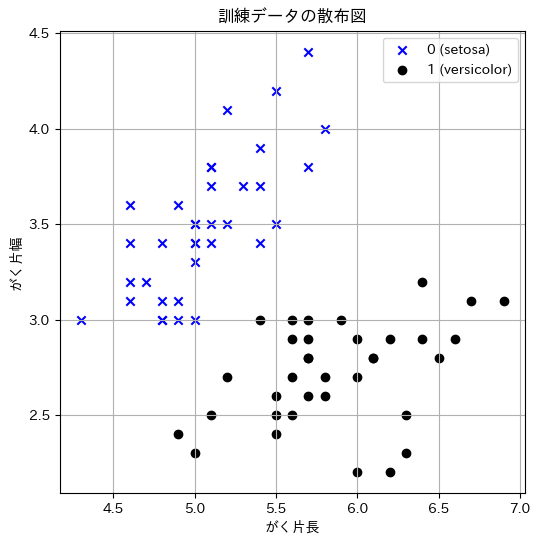

In [13]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 散布図表示
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k', label='1 (versicolor)')

# グラフのキレイ化
plt.title('訓練データの散布図')
plt.xlabel('がく片長')
plt.ylabel('がく片幅')
plt.legend()
plt.grid()
plt.show()

### 学習準備

#### 学習用変数の設定

In [14]:
# 学習用変数の設定
x = x_train
yt = y_train

# 入力データ x の先頭5行の表示 (ダミーデータを含む)
print(x[:5])

# 正解値 yt の先頭5行の表示
print(yt[:5])

[[1.  5.1 3.7]
 [1.  5.5 2.6]
 [1.  5.5 4.2]
 [1.  5.6 2.5]
 [1.  5.4 3. ]]
[0 1 0 1 1]


### 関数定義

#### シグモイド関数

In [15]:
def sigmoid(x):
    return 1/(1+ np.exp(-x))

#### 予測関数

In [16]:
def pred(x, w):
    return sigmoid(x @ w)

#### 損失関数(交差エントロピー関数)

In [17]:
def cross_entropy(yt, yp):
    # 交差エントロピーの計算(この段階ではベクトル)
    ce1 = -(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))
    # 交差エントロピーベクトルの平均値を計算
    return(np.mean(ce1))

#### classify (確率値から0/1を判定)

In [18]:
def classify(y):
    return np.where(y < 0.5, 0, 1)

 ####  evaluate(損失と精度を計算)

In [19]:
from sklearn.metrics import accuracy_score
def evaluate(xt, yt, w):

    # 予測値の計算
    yp = pred(xt, w)

    # 損失関数値の計算
    loss = cross_entropy(yt, yp)

    # 予測値(確率値)を0または1に変換
    yp_b = classify(yp)

    #精度の算出
    score = accuracy_score(yt, yp_b)
    return loss, score

### 学習

#### 初期設定

In [20]:
# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む)
D = x.shape[1]

# 繰り返し回数
iters = 5000

# 学習率
alpha = 0.01

# 初期値
w = np.ones(D)

# 評価結果記録用 (損失関数と精度)
history = np.zeros((0,3))

 #### 繰り返し処理

In [21]:
for k in range(iters):

    # 予測値の計算
    yp = pred(x, w)

    # 誤差の計算
    yd = yp - yt

    # 勾配降下法の実施
    w = w - alpha * (x.T @ yd) / M

    # ログ記録用
    if ( k % 10 == 0):
        loss, score = evaluate(x_test, y_test, w)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print( f'iter = {k}  loss = {loss:.04f} score = {score:.04f}')


iter = 0  loss = 4.4938 score = 0.5000
iter = 10  loss = 3.5654 score = 0.5000
iter = 20  loss = 2.6433 score = 0.5000
iter = 30  loss = 1.7624 score = 0.5000
iter = 40  loss = 1.0854 score = 0.5000
iter = 50  loss = 0.8187 score = 0.5000
iter = 60  loss = 0.7709 score = 0.5000
iter = 70  loss = 0.7611 score = 0.3333
iter = 80  loss = 0.7545 score = 0.2000
iter = 90  loss = 0.7478 score = 0.1667
iter = 100  loss = 0.7410 score = 0.1333
iter = 110  loss = 0.7342 score = 0.1667
iter = 120  loss = 0.7275 score = 0.2000
iter = 130  loss = 0.7209 score = 0.2000
iter = 140  loss = 0.7144 score = 0.2667
iter = 150  loss = 0.7080 score = 0.3000
iter = 160  loss = 0.7017 score = 0.3667
iter = 170  loss = 0.6955 score = 0.4333
iter = 180  loss = 0.6894 score = 0.5000
iter = 190  loss = 0.6834 score = 0.5667
iter = 200  loss = 0.6775 score = 0.7000
iter = 210  loss = 0.6717 score = 0.7000
iter = 220  loss = 0.6660 score = 0.7333
iter = 230  loss = 0.6604 score = 0.7667
iter = 240  loss = 0.6549 s

### 結果分析

#### 損失・精度確認

In [22]:
print(f'初期状態: 損失関数:{history[0,1]:.04f} 精度:{history[0,2]:.04f}')
print(f'最終状態: 損失関数:{history[-1,1]:.04f} 精度:{history[-1,2]:.04f}')

初期状態: 損失関数:4.4938 精度:0.5000
最終状態: 損失関数:0.1933 精度:0.9667


#### 学習曲線表示(損失)

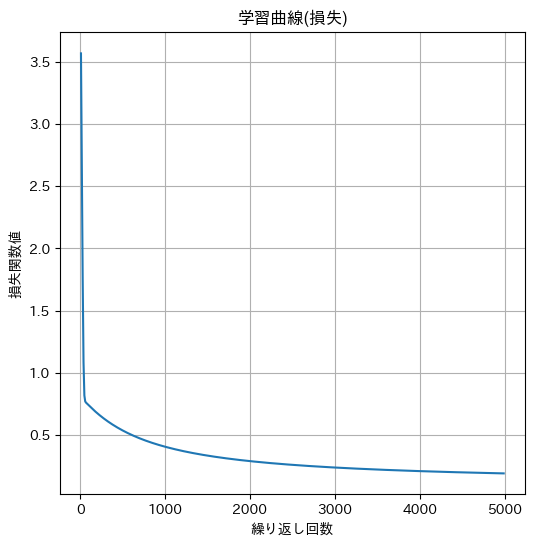

In [25]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 学習曲線の表示 (最初の1個分を除く)
plt.plot(history[1:,0], history[1:,1])

# グラフのキレイ化
plt.title('学習曲線(損失)')
plt.grid()
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.show()

#### 学習曲線表示(精度)

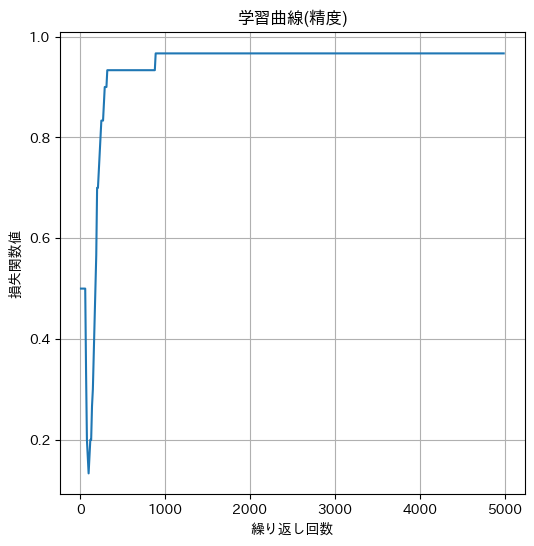

In [26]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 学習曲線の表示 (最初の1個分を除く)
plt.plot(history[1:,0], history[1:,2])

# グラフのキレイ化
plt.title('学習曲線(精度)')
plt.grid()
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.show()

#### 決定境界表示

In [27]:
# y_testの値を元にx_testを分割
x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

# 決定境界描画用 x(x1)の値からy(x2)の値を計算する
def b(x, w):
    return(-(w[0] + w[1] * x)/ w[2])

# 散布図のx1の最小値と最大値
xl = np.asarray([x[:,1].min(), x[:,1].max()])

# 対応する決定境界のy座標を計算
yl = b(xl, w)

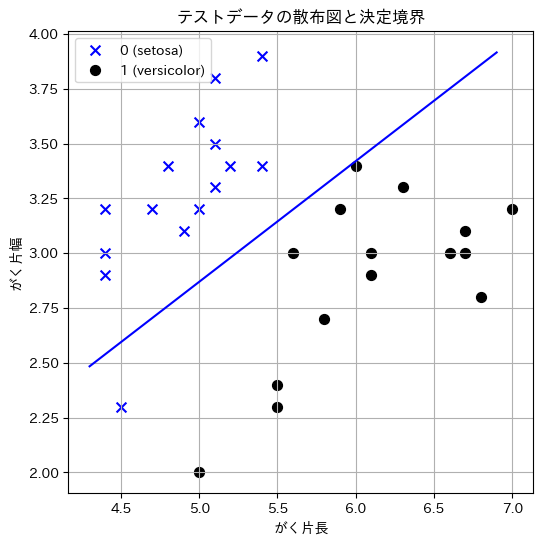

In [28]:
# グラフのサイズ指定
plt.figure(figsize=(6,6))

# 散布図の表示
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x',c='b', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o',c='k', s=50, label='1 (versicolor)')

# 決定境界の直線を追記
plt.plot(xl, yl, c='b')

# グラフのキレイ化
plt.title('テストデータの散布図と決定境界')
plt.xlabel('がく片長')
plt.ylabel('がく片幅')
plt.legend()
plt.grid()
plt.show()

#### 予測関数の3次元曲面表示

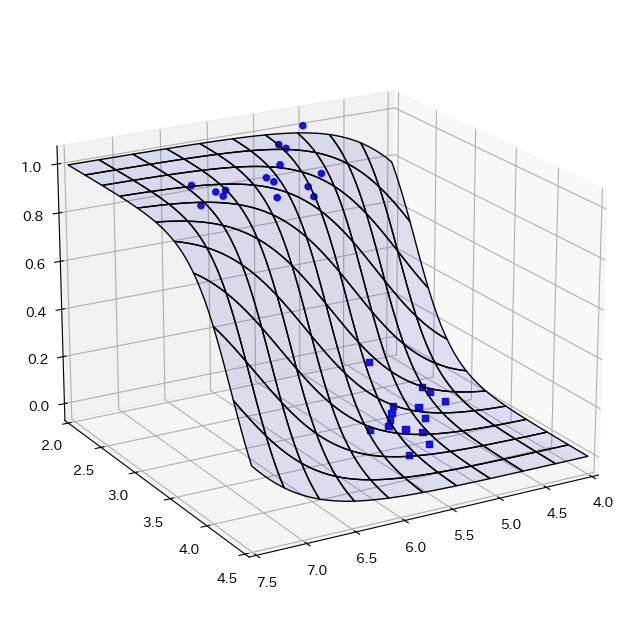

In [29]:
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(2, 4.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.asarray([np.ones(xx1.ravel().shape),
    xx1.ravel(), xx2.ravel()]).T
c = pred(xxx, w).reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c, color='blue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.1)
ax.scatter(x_t1[:,1], x_t1[:,2], 1, s=20, alpha=0.9, marker='o', c='b')
ax.scatter(x_t0[:,1], x_t0[:,2], 0, s=20, alpha=0.9, marker='s', c='b')
ax.set_xlim(4,7.5)
ax.set_ylim(2,4.5)
ax.view_init(elev=20, azim=60)

### scikit-learnを利用したモデルとの比較

In [30]:
# 必要ライブラリのロード
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# モデル生成
model_lr = LogisticRegression(solver='liblinear')
model_svm = svm.SVC(kernel='linear')

# 機械学習実施
model_lr.fit(x, yt)
model_svm.fit(x, yt)

SVC(kernel='linear')

#### 決定直線の算出

In [31]:
# 線形回帰
# 切片の値
lr_w0 = model_lr.intercept_[0]
# x1(sepal_length)の係数
lr_w1 = model_lr.coef_[0,1]
# x2(sepal_width)の係数
lr_w2 = model_lr.coef_[0,2]

def rl(x):
    wk = lr_w0 + lr_w1 * x
    wk2 = -wk / lr_w2
    return(wk2)

y_rl = rl(xl)

# 結果確認
print(xl, y_rl)

[4.3 6.9] [2.50344682 4.05984593]


In [32]:
# SVM
# 切片の値
svm_w0 = model_svm.intercept_[0]
# x1(sepal_length)の係数
svm_w1 = model_svm.coef_[0,1]
# x2(sepal_width)の係数
svm_w2 = model_svm.coef_[0,2]

def svm(x):
    wk = svm_w0 + svm_w1 * x
    wk2 = -wk / svm_w2
    return(wk2)

y_svm = svm(xl)

# 結果確認
print(xl,y_svm)

[4.3 6.9] [2.17911792 4.42574136]


#### 散布図と決定直線の同時表示

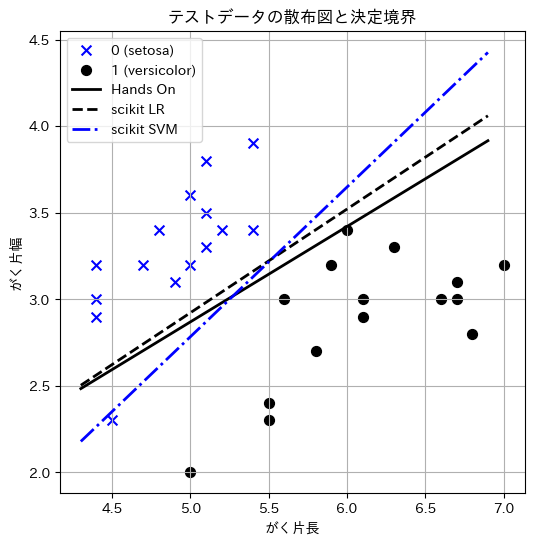

In [33]:
plt.figure(figsize=(6,6))

# 散布図の表示
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x',c='b', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o',c='k', s=50, label='1 (versicolor)')

# 決定直線の表示
plt.plot(xl, yl, linewidth=2, c='k', label='Hands On')
# lr model
plt.plot(xl, y_rl, linewidth=2, c='k', linestyle="--", label='scikit LR')
# svm
plt.plot(xl, y_svm, linewidth=2, c='b', linestyle="-.", label='scikit SVM')

# グラフのキレイ化
plt.title('テストデータの散布図と決定境界')
plt.xlabel('がく片長')
plt.ylabel('がく片幅')
plt.legend()
plt.grid()
plt.show()

### バージョン確認

In [34]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00
numpy              : 1.26.4
IPython            : 7.34.0
japanize_matplotlib: 1.1.3
matplotlib         : 3.8.0
pandas             : 2.2.2
sklearn            : 1.6.0

